<a href="https://colab.research.google.com/github/lia-ang/BME3053C_ECG_Project/blob/main/final_project_ecg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Group Project: Angela Liang, Ece Sarioglu, Ankitha Nath, Siri Yarrapatni, Vivian Lam, Alana Young

Repositories: https://github.com/huggingface/transformers/tree/main/src/transformers/models/longformer
https://github.com/allenai/longformer

Dataset: https://physionet.org/content/ecg-arrhythmia/1.0.0/

In [3]:
# Import libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for signal processing
from scipy.signal import butter, lfilter, welch

# Import libraries for machine learning and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Import PyTorch and Hugging Face Transformers for Longformer
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import LongformerTokenizer, LongformerModel, LongformerForSequenceClassification

# Import additional utilities
import os
import warnings
warnings.filterwarnings('ignore')

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Install required libraries
#pip install wfdb
#pip install transformers
#pip install datasets
#pip install scikit-learn


In [9]:
import wfdb

# Load from the folder structure
record = wfdb.rdrecord('JS00001')
signal = record.p_signal

print("Shape:", signal.shape)  # Should be (5000, 12)

Shape: (5000, 12)


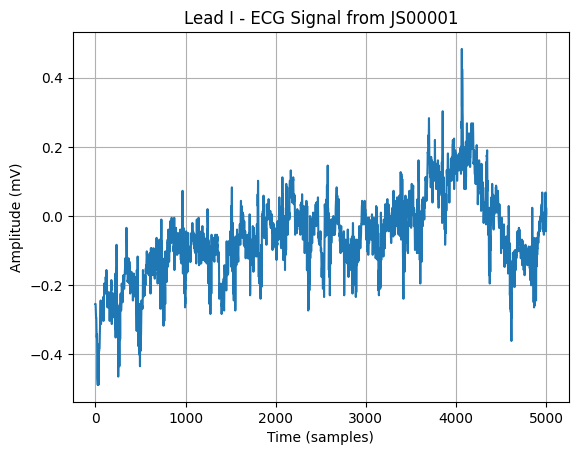

In [10]:
import matplotlib.pyplot as plt

plt.plot(signal[:, 0])
plt.title("Lead I - ECG Signal from JS00001")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.show()